In [1431]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os
import math

from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

# Read file

In [1432]:
#f=pd.read_excel('CPI-RST-ALL.xlsx')
f=pd.read_csv('CPI-RST-ALL.csv')
o=pd.read_csv('Structure-zone-owc.csv')
co=pd.read_csv('coefficient.csv')

# K-phi Coefficient & J-function

In [1433]:
co

coe     PRT1     PRT2      PRT3       PRT4      PRT5    PRT6
0       c  8.05121  9.47905  11.48070  11.004900  7.544220  9.1850
1       d -1.51538 -1.35805  -1.15673  -0.092696 -0.229526 -1.5250
2       a  0.29750  0.35390   0.35390   0.353900  0.477700  0.4777
3  lambda -0.30000 -0.27990  -0.27990  -0.279900 -0.234900 -0.2349
4       b  0.19800  0.00140   0.00140   0.001400 -0.119800 -0.1198

# Choose Strucure & Zone

In [1434]:
#st = 'AA'
#st = 'AB'
st = 'B'
#st = 'CD'
#st = 'CA'
#st = 'CB'

zz = 'zone2'
#zz = 'zone3A'
#zz = 'zone3A2'
#zz = 'zone3B'
#zz = 'zone3C'
#zz = 'zone4A'
#zz = 'zone4B'
#zz = 'zone4C'
#zz = 'zone5A0'
#zz = 'zone5A1'
#zz = 'zone5A2'
#zz = 'zone5A3'
#zz = 'zone5B'
#zz = 'zone5C'
#zz = 'zone5E'
#zz = 'zone5F'

* Interfacial tension

In [1435]:
IFT=10
theta=30
sigmacos=IFT*np.cos(theta/360*2*np.pi)

* owc
* oil & water density 
* Plot range

In [1436]:
owc=o.owc[(o.stru==st) & (o.zone==zz)].values[0]
Wat_density=o.watdensity[(o.stru==st) & (o.zone==zz)].values[0]
Oil_density=o.oildensity[(o.stru==st) & (o.zone==zz)].values[0]
yrange_max=owc + 15
yrange_min=owc - 55 # 55 CD4A=80 CD5B=80 CD5C=80 CD5F=80 B5B=70

# fz Dataframe is set by zone & strucure

In [1437]:
fz=f[(f.zone==zz) & (f.Str==st)]

fz=fz.assign(
    Height= owc-fz.SSTVD_Z,
)
fz=fz.assign(
    Pc= fz.Height*(Wat_density-Oil_density)/144
)

In [1438]:
fz.columns

Index(['Str', 'WELL', 'DEPTH', 'SSTVD_Z', 'Zones', 'z', 'zone', 'PRT2014',
       'OH_year', 'SW', 'PHIE', 'RST_year1', 'RST_PHIE1', 'RST_PSW1',
       'RST_SW1', 'RST_year2', 'RST_PHIE2', 'RST_PSW2', 'RST_SW2', 'RST_year3',
       'RST_PHIE3', 'RST_PSW3', 'RST_SW3', 'RST_year4', 'RST_PHIE4',
       'RST_PSW4', 'RST_SW4', 'Height', 'Pc'],
      dtype='object')

# 2006RST-log well

In [1439]:
if st == 'AA':
    fz2006=fz[(fz.WELL=='AA2ST')|(fz.WELL=='MR4')]
if st == 'AB':
    fz2006=fz[(fz.WELL=='AA2ST')|(fz.WELL=='MR4')]
elif st == 'B':
    fz2006=fz[(fz.WELL=='BB1')|(fz.WELL=='BB2')|(fz.WELL=='BD1')|(fz.WELL=='BD2')|(fz.WELL=='MR5')|(fz.WELL=='BE1')]
elif st == 'CD':
    fz2006=fz[(fz.WELL=='MR3')|(fz.WELL=='CD2')|(fz.WELL=='CD5')|(fz.WELL=='CD6')|(fz.WELL=='CD8')|(fz.WELL=='CD9')|(fz.WELL=='CD12')]
elif st == 'CB':
    fz2006=fz[fz.WELL=='CB1']
elif st == 'CA':    
    fz2006=fz[fz.WELL=='MR3']

# All Log in each strucure

In [1440]:
if st == 'AA':
    wname=['MR4','MR4ST','AA1D','AA1ST','AA2D','AA2ST','AA3D','AA3ST','AC1','AC1ST']
elif st == 'AB':
    wname=['MR1','AB1','AB2']
elif st == 'B':
    wname=['BA1','BA2','BA2ST','BA3','BB1','BB2','BB3','BB3ST','BB4','BB5','BB6','BB7','BC1',
           'BD1','BD1ST','BD2','BD3','BD4','BD5','BD6','BD7','BE1','BF1','BF2','MR2','MR2ST','MR5']
elif st == 'CD':
    wname=['CD1','CD2','CD3','CD4','CD4H','CD5','CD5H','CD6','CD6H','CD6H3','CD7','CD8','CD8H',
           'CD9','CD10','CD11','CD12','CD13','CD14','CD15','CE1']
elif st == 'CB':    
    wname=['CB1','CB2','CB2H','CB3']
elif st == 'CA':    
    wname=['MR3','CA1'] 

# Perm & PHIE5
* Definition

In [1441]:
phi1=0.025
phi2=0.075
phi3=0.125
phi4=0.175
phi5=0.225

t3=np.arange(owc-70, owc+1, 1)
df=pd.DataFrame({'TVDSS':t3})
df=df.assign(
    Height= owc-df.TVDSS,
)
df=df.assign(
    Pc= df.Height*(Wat_density-Oil_density)/144,
    poro1 = phi1,
    poro2 = phi2,
    poro3 = phi3,
    poro4 = phi4,
    poro5 = phi5,
    prt1=1,
    prt2=2,
    prt3=3,
    prt4=4,
    prt5=5,
    prt6=6,
)

def PERM(rt, phi):
    if (rt==1):
        return 10**(co.PRT1[co.coe=='c'].values[0]* phi + co.PRT1[co.coe=='d'].values[0])
    elif (rt==2):
        return 10**(co.PRT2[co.coe=='c'].values[0]* phi + co.PRT2[co.coe=='d'].values[0])
    elif (rt==3):
        return 10**(co.PRT3[co.coe=='c'].values[0]* phi + co.PRT3[co.coe=='d'].values[0])
    elif (rt==4):
        return 10**(co.PRT4[co.coe=='c'].values[0]* phi + co.PRT4[co.coe=='d'].values[0])
    elif (rt==5):
        return 10**(co.PRT5[co.coe=='c'].values[0]* phi + co.PRT5[co.coe=='d'].values[0])
    elif (rt==6):
        return 10**(co.PRT6[co.coe=='c'].values[0]* phi + co.PRT6[co.coe=='d'].values[0])
    else:
        return None

def SWI(rt, phi, PC, KK):
    if (rt==1 and phi>0.0):
        aa=co.PRT1[co.coe=='a'].values[0]
        lam=co.PRT1[co.coe=='lambda'].values[0]
        bb=co.PRT1[co.coe=='b'].values[0]
        swx =aa*((0.2166* PC/sigmacos*np.sqrt(KK/phi))**lam)+bb 
        if (swx>1): swx=1.0
        return  swx
    elif (rt==2 and phi>0.0):
        aa=co.PRT2[co.coe=='a'].values[0]
        lam=co.PRT2[co.coe=='lambda'].values[0]
        bb=co.PRT2[co.coe=='b'].values[0]
        swx = aa*((0.2166* PC/sigmacos*np.sqrt(KK/phi))**lam)+bb
        if (swx>1): swx=1.0
        return swx
    elif (rt==3 and phi>0.0):
        aa=co.PRT3[co.coe=='a'].values[0]
        lam=co.PRT3[co.coe=='lambda'].values[0]
        bb=co.PRT3[co.coe=='b'].values[0]
        swx = aa*((0.2166* PC/sigmacos*np.sqrt(KK/phi))**lam)+bb
        if (swx>1): swx=1.0
        return swx
    elif (rt==4 and phi>0.0):
        aa=co.PRT4[co.coe=='a'].values[0]
        lam=co.PRT4[co.coe=='lambda'].values[0]
        bb=co.PRT4[co.coe=='b'].values[0]
        swx = aa*((0.2166* PC/sigmacos*np.sqrt(KK/phi))**lam)+bb
        if (swx>1): swx=1.0
        return swx    
    elif (rt==5 and phi>0.0):
        aa=co.PRT5[co.coe=='a'].values[0]
        lam=co.PRT5[co.coe=='lambda'].values[0]
        bb=co.PRT5[co.coe=='b'].values[0]
        swx = aa*((0.2166* PC/sigmacos*np.sqrt(KK/phi))**lam)+bb
        if (swx>1): swx=1.0
        return swx      
    elif (rt==6 and phi>0.0):
        aa=co.PRT6[co.coe=='a'].values[0]
        lam=co.PRT6[co.coe=='lambda'].values[0]
        bb=co.PRT6[co.coe=='b'].values[0]
        swx = aa*((0.2166* PC/sigmacos*np.sqrt(KK/phi))**lam)+bb
        if (swx>1): swx=1.0
        return swx  

    
def PHIE5(phi):
    if (phi>=0.0 and phi<0.05):
        return phi1
    elif (phi>=0.05 and phi<0.10):
        return phi2
    elif (phi>=0.10 and phi<0.15):
        return phi3
    elif (phi>=0.15 and phi<0.20):
        return phi4
    elif (phi>=0.20 and phi<1.00):
        return phi5
    else:
        return None
  

# Add K and Sw into df Dataframe

* Reference
http://sinhrks.hatenablog.com/entry/2015/07/11/223124

In [1442]:
for rt in [1, 2, 3, 4, 5, 6]:
    for i in [1,2,3,4,5]:
        k_n = 'K' + str(rt) + '_' + str(i)
        sw_n = 'Sw' + str(rt) + '_' + str(i)
        po_n = 'poro' + str(i)
        prt_n = 'prt' + str(rt)
        
        df[k_n]=pd.Series(np.vectorize(PERM)(df[prt_n], df[po_n]), index=df.index)
        df[sw_n]=pd.Series(np.vectorize(SWI)(df[prt_n], df[po_n], df['Pc'], df[k_n]), index=df.index)

# J-function
* PRT1: blue
* PRT2: cyan
* PRT3: yellow
* PRT4: magenta
* PRT5: red (dotted line)
* PRT6: black (dotted line)


* phi1=0.025
* phi2=0.075
* phi3=0.125
* phi4=0.175
* phi5=0.225

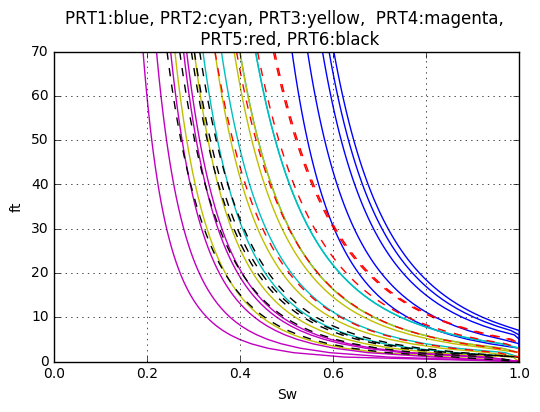

In [1443]:
#plt.figure(figsize=(8,4))
plt.grid(True)
plt.title('PRT1:blue, PRT2:cyan, PRT3:yellow,  PRT4:magenta, \n PRT5:red, PRT6:black')
plt.xlim(0,1)
plt.xlabel('Sw')
plt.ylabel('ft')
for rt, cc in zip([1, 2, 3, 4, 5, 6], ['b-', 'c-', 'y-', 'm-', 'k--', 'r--']):
    for i in [1,2,3,4,5]:
        x1 = 'Sw' + str(rt) + '_' + str(i)
        plt.plot(df[x1], owc-df.TVDSS, cc)
    
#plt.savefig('PRT1_6-Pc.png', bbox_inches='tight')

# PHIE_ALL 
## If CPI-log does not exist, RST-log is set

In [1444]:
def f2_2(x, y):
    if x > 0:
        return x
    else:
        return y

fz['PHIE_ALL']=pd.Series(np.vectorize(f2_2)(fz['PHIE'], fz['RST_PHIE1']), index=fz.index)

In [1445]:
fz1=fz.copy()


#fz1['PHIE_5']=pd.Series(np.vectorize(PHIE5)(fz1['PHIE']), index=fz1.index)
fz1['PHIE_5']=pd.Series(np.vectorize(PHIE5)(fz1['PHIE_ALL']), index=fz1.index)
fz1['K_CPI']=pd.Series(np.vectorize(PERM)(fz1['PRT2014'], fz1['PHIE_5']), index=fz1.index)
fz1['SWcheck']=pd.Series(np.vectorize(SWI)(fz1['PRT2014'], fz1['PHIE_5'], fz1['Pc'], fz1['K_CPI']), index=fz1.index)

# Example

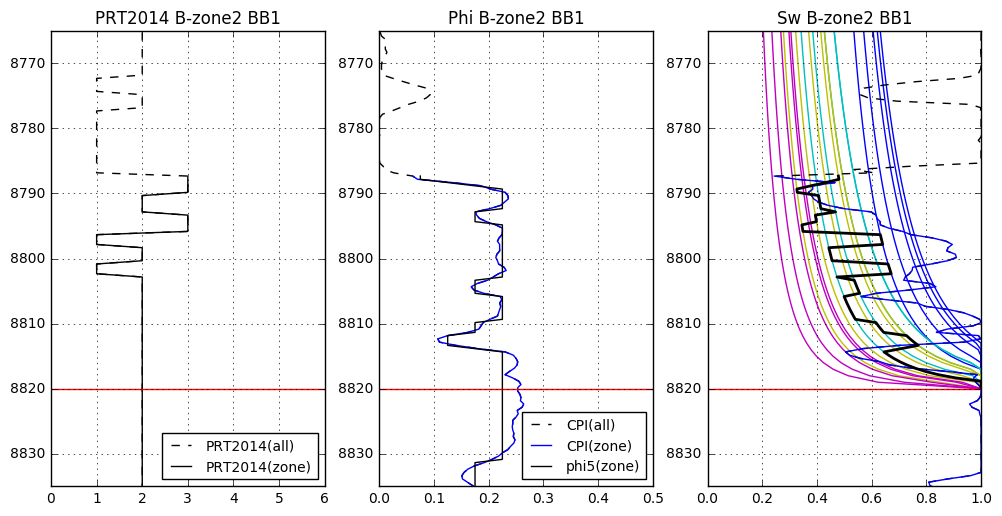

In [1446]:
plt.figure(figsize=(12,20))
#www='CD2' ## CD5
www='BB1'
#www='MR4'
plt.subplot(3,3,1)
plt.title('PRT2014 ' + st + '-' + zz +' '+ www)
plt.plot(f.PRT2014[f.WELL==www], f.SSTVD_Z[f.WELL==www], 'k--', label='PRT2014(all)')
plt.plot(fz1.PRT2014[fz.WELL==www], fz1.SSTVD_Z[fz.WELL==www], 'k-', label='PRT2014(zone)')

plt.legend(loc=4,prop={'size':10})
plt.ticklabel_format(useOffset=False)

plt.plot((0, 6), (owc, owc), 'r-')
plt.xlim(0,6)
plt.ylim(yrange_min,yrange_max)
plt.gca().invert_yaxis()
plt.grid(True)

####################################
plt.subplot(3,3,2)
plt.title('Phi ' + st + '-' + zz +' '+ www)
plt.plot(f.PHIE[f.WELL==www], f.SSTVD_Z[f.WELL==www], 'k--', label='CPI(all)')
plt.plot(fz.PHIE[fz.WELL==www], fz.SSTVD_Z[fz.WELL==www], 'b-', label='CPI(zone)')
plt.plot(fz1.PHIE_5[fz.WELL==www], fz1.SSTVD_Z[fz.WELL==www], 'k-', label='phi5(zone)')

plt.legend(loc=4,prop={'size':10})
plt.ticklabel_format(useOffset=False)

plt.plot((0, 1), (owc, owc), 'r-')
plt.xlim(0,0.5)
plt.ylim(yrange_min,yrange_max)
plt.gca().invert_yaxis()
plt.grid(True)

####################################
plt.subplot(3,3,3)
plt.title('Sw ' + st + '-' + zz +' '+ www)

for rt, cc in zip([1, 2, 3, 4], ['b-', 'c-', 'y-', 'm-']):
    for i in [1,2,3,4,5]:
        x1 = 'Sw' + str(rt) + '_' + str(i)
        plt.plot(df[x1], df.TVDSS, cc)


plt.plot(f.SW[f.WELL==www], f.SSTVD_Z[f.WELL==www], 'k--', label='CPI(all)')
plt.plot(fz.SW[fz.WELL==www], fz.SSTVD_Z[fz.WELL==www], 'b-', label='CPI(zone)')
plt.plot(fz1.SWcheck[fz.WELL==www], fz1.SSTVD_Z[fz.WELL==www], 'k-', label='check', lw='2')



#plt.legend(loc=3,prop={'size':7})
plt.ticklabel_format(useOffset=False)

plt.plot((0, 1), (owc, owc), 'r-')
plt.xlim(0,1)
plt.ylim(yrange_min,yrange_max)
plt.gca().invert_yaxis()
plt.grid(True)

#plt.savefig('Check_Pc.png', bbox_inches='tight')
plt.savefig( 'Check_Pc-' +st + '-'+ zz + '_'+ www + '.png', bbox_inches='tight') 

# All log data from Petrel
* CPI-log: blue
* RST-log: Black 1st Solid line
* RST-log: Black 2nd and Later Dotted line

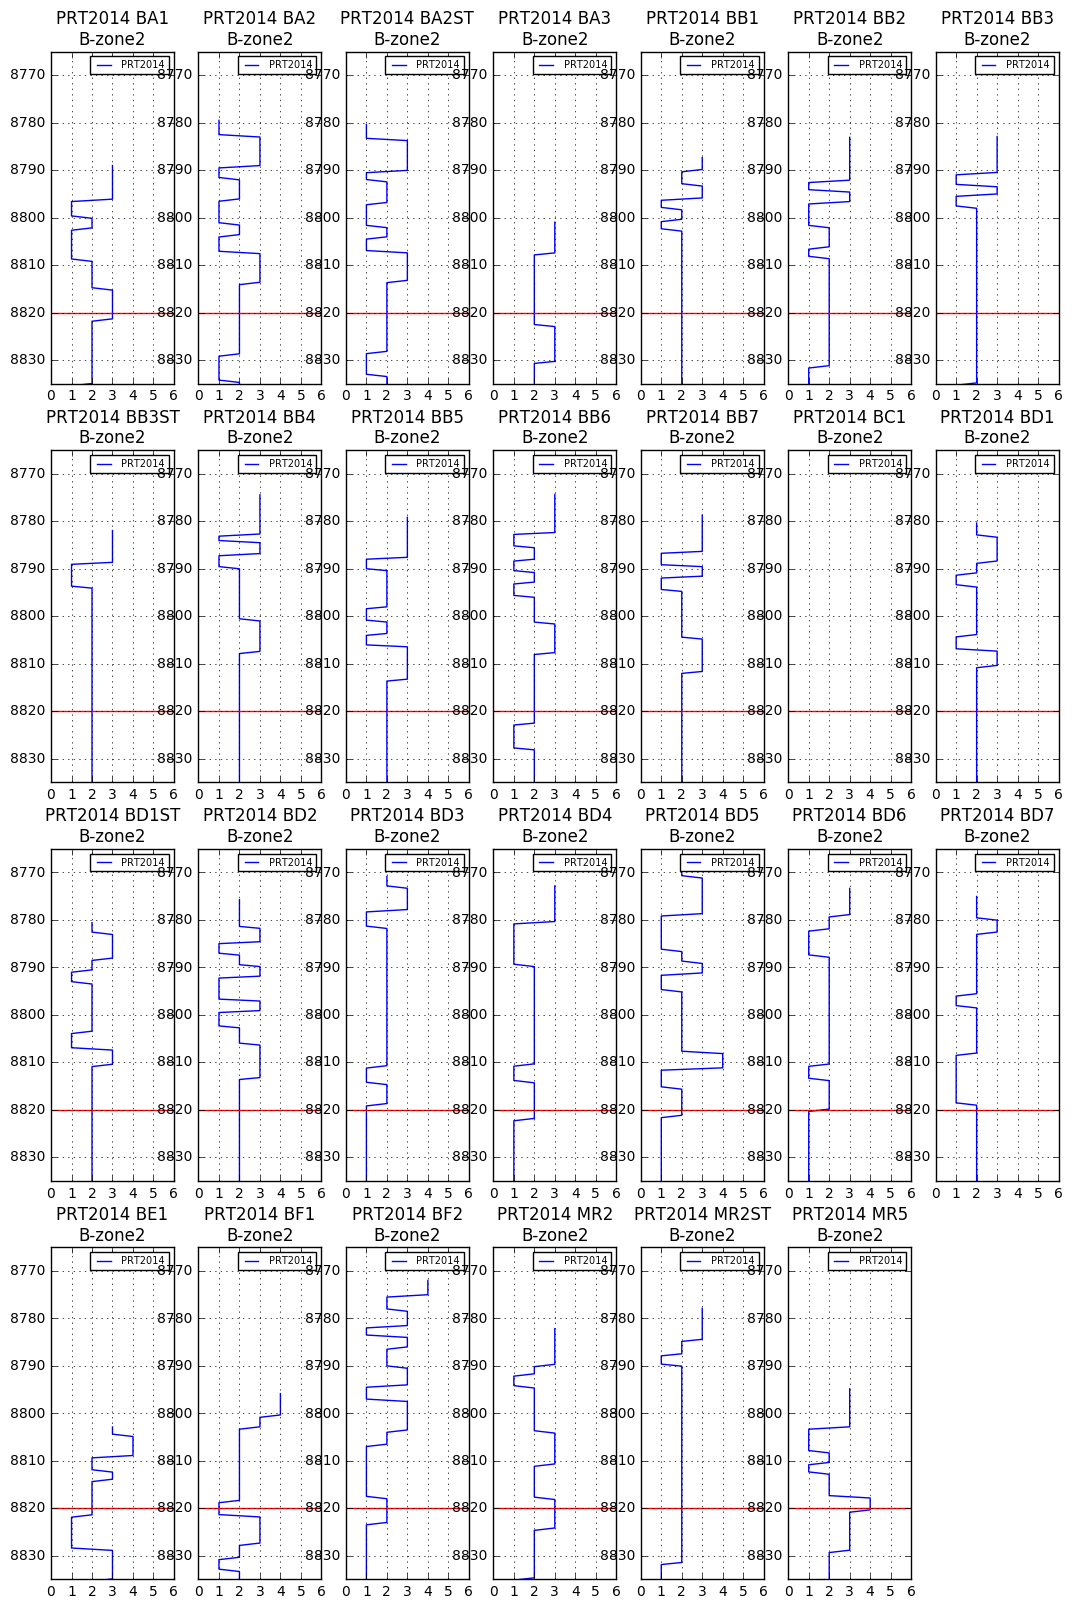

In [1447]:
plt.figure(figsize=(13,30))
i=0
for w in wname:
    i=i+1
    plt.subplot(6,7,i)
    plt.title('PRT2014 '+ w +'\n'+ st + '-' + zz)
    #plt.title('PRT2014 \n' + st + '-' + zz +' '+ w)

    #plt.plot(f.PRT2014[f.WELL==w], f.SSTVD_Z[f.WELL==w], 'k:', label='PRT2014')
    plt.plot(fz1.PRT2014[fz.WELL==w], fz1.SSTVD_Z[fz.WELL==w], 'b-', label='PRT2014')
    plt.legend(loc=1,prop={'size':7})
    plt.ticklabel_format(useOffset=False)


    plt.plot((0, 6), (owc, owc), 'r-')
    plt.xlim(0,6)
    plt.ylim(yrange_min,yrange_max)
    plt.gca().invert_yaxis()
    plt.grid(True)
    
plt.savefig( 'PRT2014Log-' +st + '-'+ zz + '.png', bbox_inches='tight')   

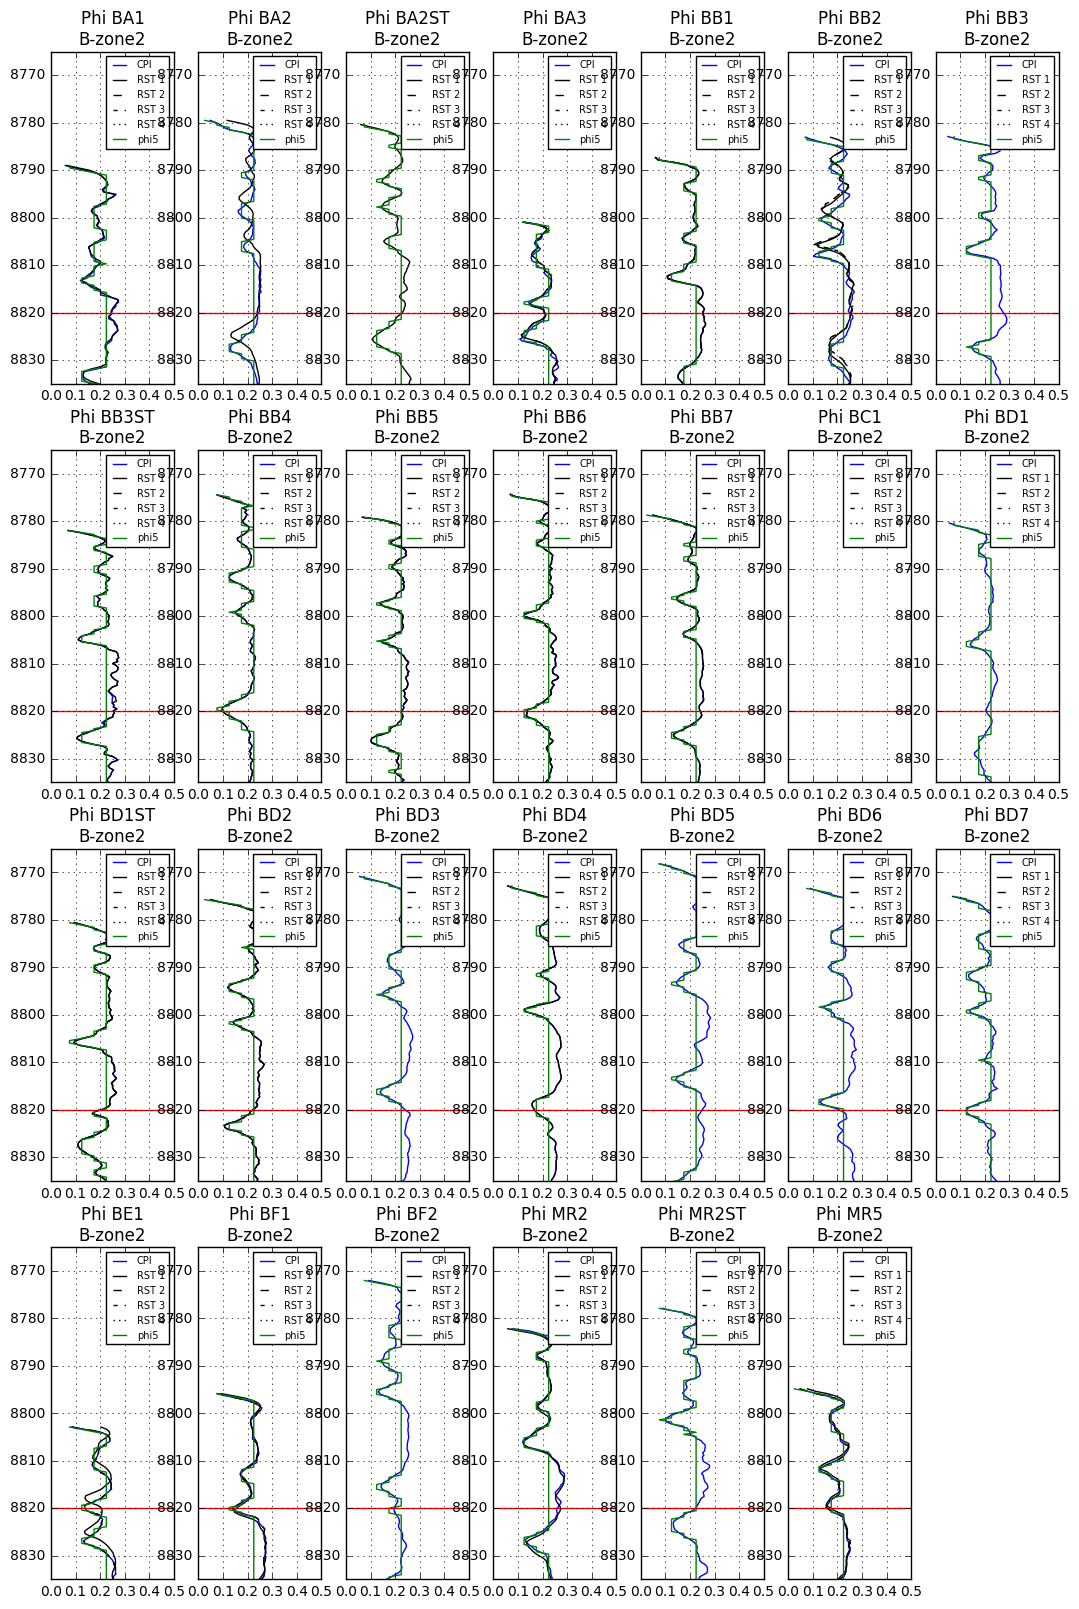

In [1448]:
plt.figure(figsize=(13,30))
i=0
for w in wname:
    i=i+1
    plt.subplot(6,7,i)
    plt.title('Phi '+ w +'\n'+ st + '-' + zz)

    #plt.plot(f.PHIE[f.WELL==w], f.SSTVD_Z[f.WELL==w], 'k:', label='CPI')

    plt.plot(fz.PHIE[fz.WELL==w], fz.SSTVD_Z[fz.WELL==w], 'b-', label='CPI')
    plt.plot(fz.RST_PHIE1[fz.WELL==w], fz.SSTVD_Z[fz.WELL==w], 'k-', label='RST 1')
    plt.plot(fz.RST_PHIE2[fz.WELL==w], fz.SSTVD_Z[fz.WELL==w], 'k--', label='RST 2')
    plt.plot(fz.RST_PHIE3[fz.WELL==w], fz.SSTVD_Z[fz.WELL==w], 'k-.', label='RST 3')
    plt.plot(fz.RST_PHIE4[fz.WELL==w], fz.SSTVD_Z[fz.WELL==w], 'k:', label='RST 4')

    plt.plot(fz1.PHIE_5[fz.WELL==w], fz1.SSTVD_Z[fz.WELL==w], 'g-', label='phi5')
    plt.legend(loc=1,prop={'size':7})
    plt.ticklabel_format(useOffset=False)


    plt.plot((0, 1), (owc, owc), 'r-')
    plt.xlim(0,0.5)
    plt.ylim(yrange_min,yrange_max)
    plt.gca().invert_yaxis()
    plt.grid(True)
    
plt.savefig( 'PhiLog-' +st + '-'+ zz + '.png', bbox_inches='tight')    

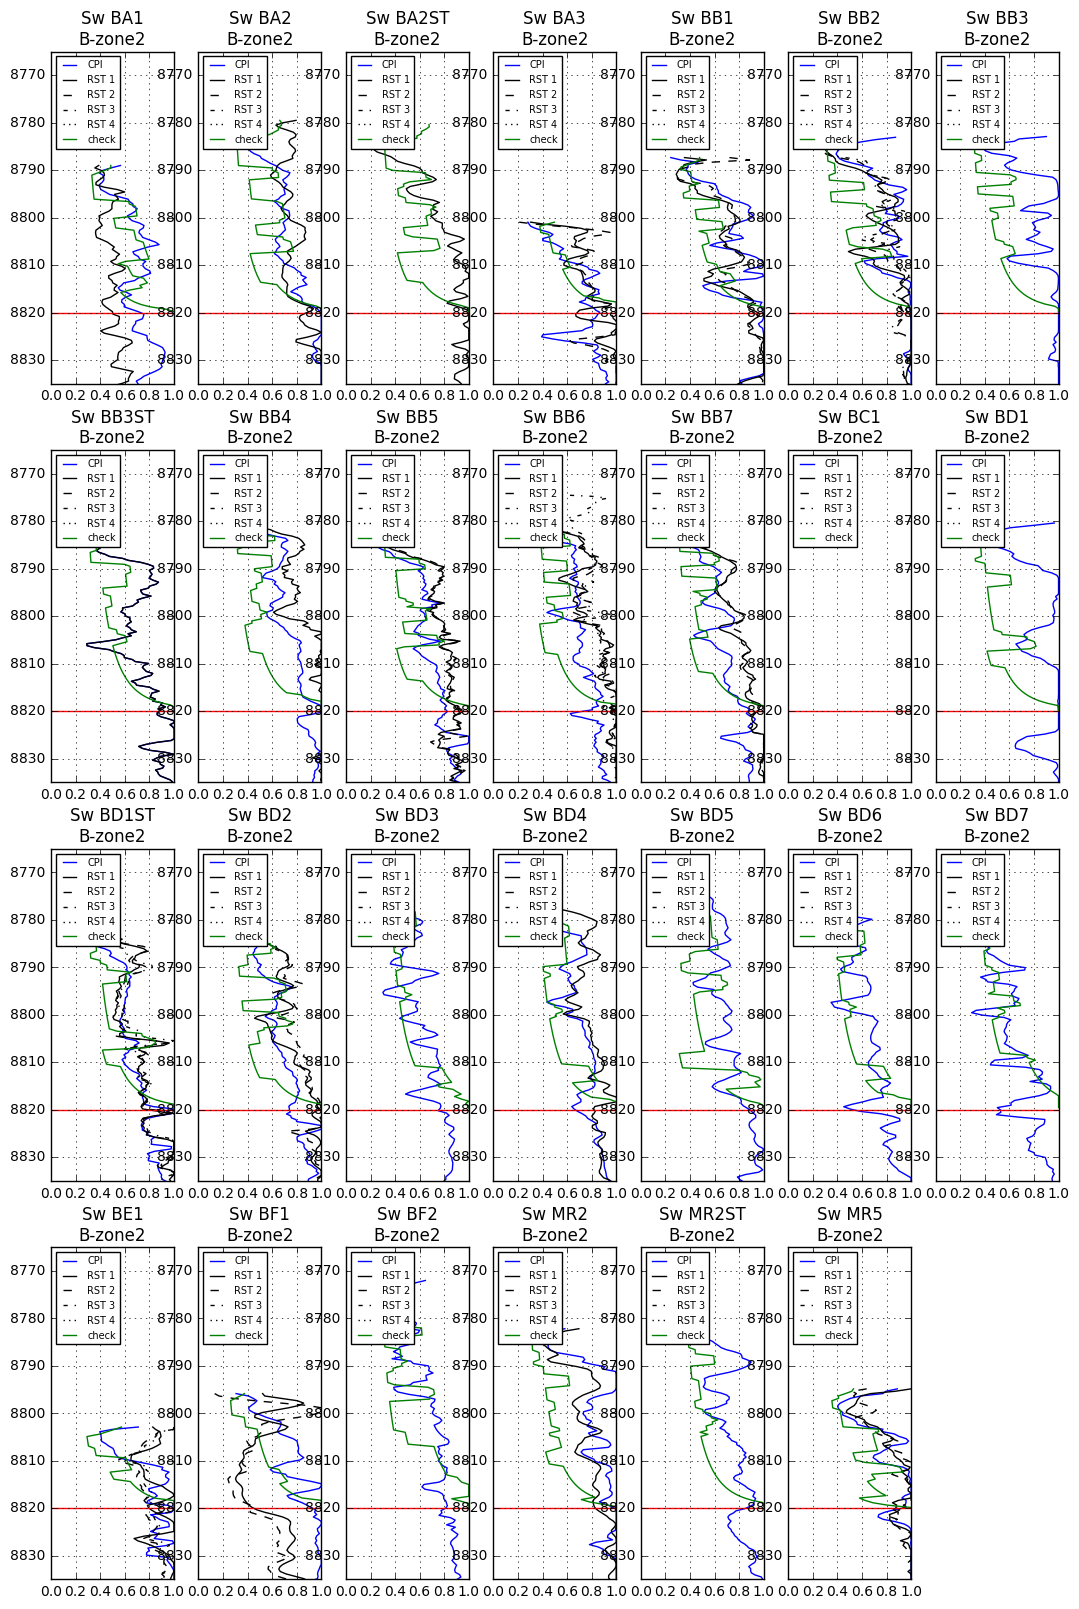

In [1449]:
plt.figure(figsize=(13,30))
i=0
for w in wname:
    i=i+1
    plt.subplot(6,7,i)
    plt.title('Sw '+ w +'\n'+ st + '-' + zz)

    #plt.plot(f.SW[f.WELL==w], f.SSTVD_Z[f.WELL==w], 'k:', label='CPI')
    
    plt.plot(fz.SW[fz.WELL==w], fz.SSTVD_Z[fz.WELL==w], 'b-', label='CPI')
    plt.plot(fz.RST_SW1[fz.WELL==w], fz.SSTVD_Z[fz.WELL==w], 'k-', label='RST 1')
    plt.plot(fz.RST_SW2[fz.WELL==w], fz.SSTVD_Z[fz.WELL==w], 'k--', label='RST 2')
    plt.plot(fz.RST_SW3[fz.WELL==w], fz.SSTVD_Z[fz.WELL==w], 'k-.', label='RST 3')
    plt.plot(fz.RST_SW4[fz.WELL==w], fz.SSTVD_Z[fz.WELL==w], 'k:', label='RST 4')
    
    plt.plot(fz1.SWcheck[fz.WELL==w], fz1.SSTVD_Z[fz.WELL==w], 'g-', label='check')
    plt.legend(loc=2,prop={'size':7})
    plt.ticklabel_format(useOffset=False)


    plt.plot((0, 1), (owc, owc), 'r-')
    plt.xlim(0,1)
    plt.ylim(yrange_min,yrange_max)
    plt.gca().invert_yaxis()
    plt.grid(True)
    
plt.savefig( 'SwLog-' +st + '-'+ zz + '.png', bbox_inches='tight')    

# Root Square Mean (RMS)
* Definition

In [1450]:
def rmsCPI(w):
    check=pd.DataFrame({
            'actCPI':fz1.SW[fz.WELL==w],
            'pre':fz1.SWcheck[fz.WELL==w],
            'h':fz1.SSTVD_Z[fz.WELL==w]
        }
    ).reset_index(drop=True).dropna()
    check = check[check.actCPI>=0]
    if len(check.pre)==0:
        rms1=0
    else:
        rms1=sqrt(mean_squared_error(check.actCPI, check.pre))
    return rms1

def rmsRST(w):
    check=pd.DataFrame({
            'actRST':fz1.RST_SW1[fz.WELL==w],
            'pre':fz1.SWcheck[fz.WELL==w],
            'h':fz1.SSTVD_Z[fz.WELL==w]
        }
    ).reset_index(drop=True).dropna()
    check = check[check.actRST>=0]
    if len(check.pre)==0:
        rms2=0
    else:
        rms2=sqrt(mean_squared_error(check.actRST, check.pre))
    return rms2

a=rmsCPI('MR2')
b=rmsRST('MR2')

RMS=pd.DataFrame({
        'well': wname
    }
)

RMS['rms_cpi']=RMS.apply(lambda x: rmsCPI(x['well']), axis=1)
RMS['rms_rst']=RMS.apply(lambda x: rmsRST(x['well']), axis=1)

cpi_mean=np.mean(RMS['rms_cpi'][RMS.rms_cpi>0])
rst_mean=np.mean(RMS['rms_rst'][RMS.rms_rst>0])

# RMS result

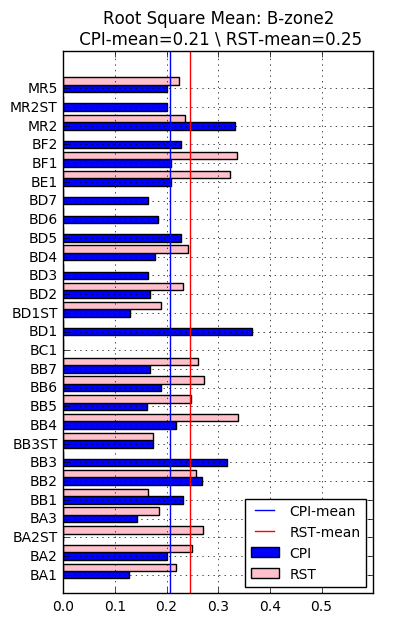

In [1451]:
fig, ax = plt.subplots()
pos=np.arange(len(RMS))

w = 0.4       # the width of the bars
ax.barh(pos, RMS.rms_cpi,color='b', height=0.4, align='center', label='CPI')
ax.barh(pos+w, RMS.rms_rst,color='pink', height=0.4, align='center', label='RST')

ax.set_yticks(pos)
ax.set_yticklabels(list(RMS.well))
ax.invert_yaxis()  # labels read top-to-bottom

plt.title('Root Square Mean: '+ st + '-' + zz + 
          '\n CPI-mean='+str(round(cpi_mean,2))+ ' \ RST-mean='+str(round(rst_mean,2)))

plt.plot((cpi_mean, cpi_mean), (-1,len(RMS)+1), 'b-', label='CPI-mean')
plt.plot((rst_mean, rst_mean), (-1,len(RMS)+1), 'r-', label='RST-mean')

plt.ylim(-1,len(RMS)+1)
plt.xlim(0,0.6)
plt.legend(loc=4,prop={'size':10})
fig.set_size_inches(4, 7)
plt.grid(True)

plt.savefig( 'RSM-' +st + '-'+ zz + '.png', bbox_inches='tight')
plt.show()

# CPI vs RST vs 2006 RST-Log

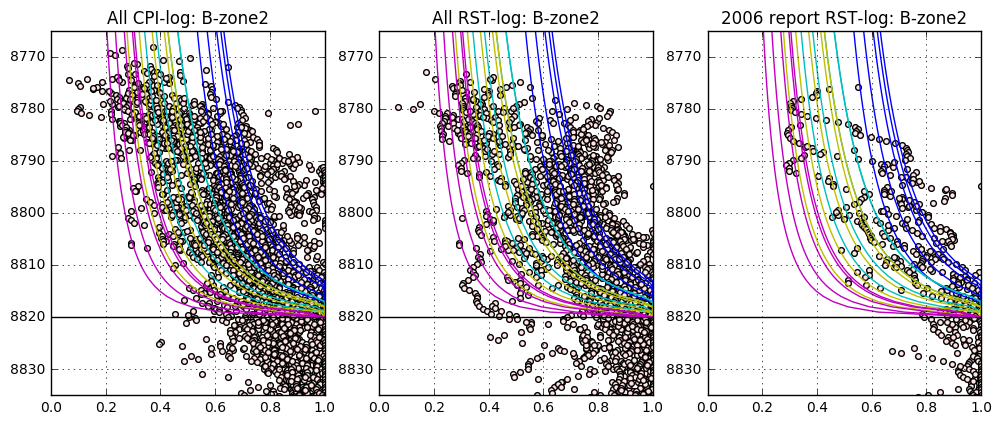

In [1452]:
def SW_SSTVD(num, x, y, color, TITLE):
    plt.subplot(3,3,num)
    plt.title(TITLE)
    plt.plot((0, 1), (owc, owc), 'k-')
    plt.scatter(x,y, c=color, s=17)#, edgecolors='')
    for rt, cc in zip([1, 2, 3, 4], ['b-', 'c-', 'y-', 'm-']):
        for i in [1,2,3,4,5]:
            x1 = 'Sw' + str(rt) + '_' + str(i)
            plt.plot(df[x1], df.TVDSS, cc)         

    plt.xlim(0,1)
    plt.ylim(yrange_min,yrange_max)
    plt.ticklabel_format(useOffset=False)
    plt.gca().invert_yaxis()
    plt.grid(True)
    if ((num>3) & (num<=6)):
        plt.colorbar(ticks=[1, 2, 3, 4, 5, 6])
    if (num>6):
        plt.colorbar()
    

plt.figure(figsize=(12,16))
tit = st + '-' + zz
SW_SSTVD(1, fz.SW, fz.SSTVD_Z, '#FFE4E1', 'All CPI-log: ' + tit)
SW_SSTVD(2, fz.RST_SW1, fz.SSTVD_Z, '#FFE4E1', 'All RST-log: ' + tit)
SW_SSTVD(3, fz2006.RST_SW1, fz2006.SSTVD_Z, '#FFE4E1', '2006 report RST-log: ' + tit)

#SW_SSTVD(4, fz.SW, fz.SSTVD_Z, fz.PRT2014, 'CPI: ' + tit + ', PRT1-6')
#SW_SSTVD(5, fz.RST_SW1, fz.SSTVD_Z, fz.PRT2014, 'RST: ' + tit + ', PRT1-6')
#SW_SSTVD(6, fz2006.RST_SW1, fz2006.SSTVD_Z, fz2006.PRT2014, '2006RST: ' + tit + ', PRT1-6')

#SW_SSTVD(7, fz.SW[fz.PHIE>0], fz.SSTVD_Z[fz.PHIE>0], fz.PHIE[fz.PHIE>0], 'CPI: ' + tit + ', PHIE')
#SW_SSTVD(8, fz.RST_SW1[fz.RST_PHIE1>0], fz.SSTVD_Z[fz.RST_PHIE1>0], fz.RST_PHIE1[fz.RST_PHIE1>0], 'RST: ' + tit + ', RST_PHIE')
#SW_SSTVD(9, fz2006.RST_SW1[fz2006.RST_PHIE1>0], fz2006.SSTVD_Z[fz2006.RST_PHIE1>0], fz2006.RST_PHIE1[fz2006.RST_PHIE1>0], '2006RST: ' + tit + ', RST_PHIE')

plt.savefig( 'Pc-' +st + '-'+ zz + '.png', bbox_inches='tight')  

# All CPI log
* PRT1,2,3,4 and 5 phi range

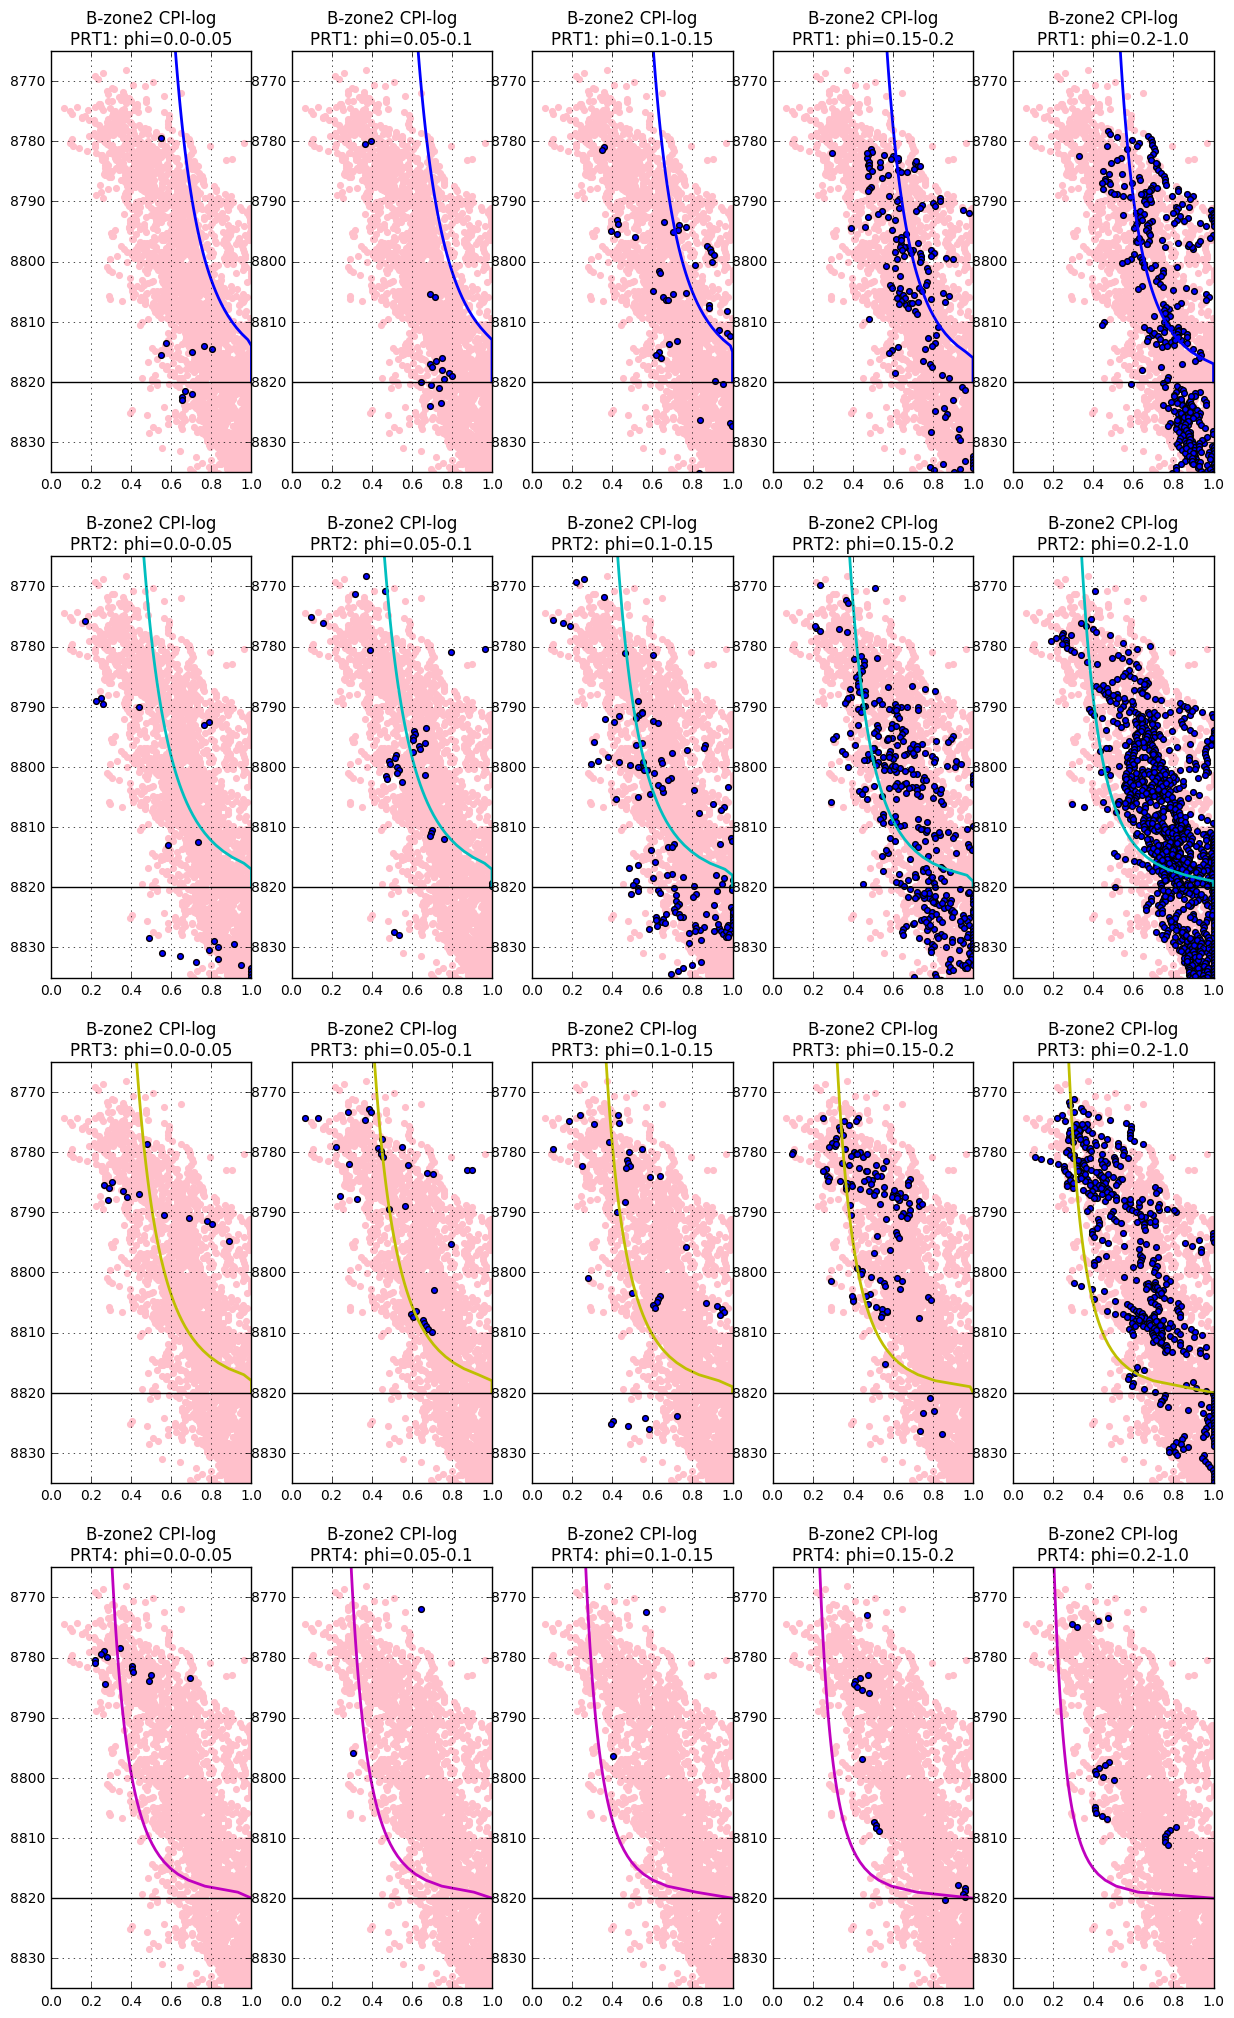

In [1453]:
plt.figure(figsize=(15,25))
i=0
for rt, cc in zip([1, 2, 3, 4], ['b-', 'c-', 'y-', 'm-']):
    for phi1, phi2, pnum in zip([0.00, 0.05, 0.10, 0.15, 0.20], [0.05, 0.10, 0.15, 0.20, 1.00],[1,2,3,4,5]):
        i=i+1
        plt.subplot(4,5,i)
        plt.title(st + '-' + zz +' CPI-log\n'+ 'PRT'+str(rt)+ ': phi='+str(phi1)+'-'+str(phi2))
        swoh=fz.SW[(fz.PRT2014==rt) & (fz.PHIE>=phi1) & (fz.PHIE<phi2)]
        ss=fz.SSTVD_Z[(fz.PRT2014==rt) & (fz.PHIE>=phi1) & (fz.PHIE<phi2)]

        plt.scatter(fz.SW,fz.SSTVD_Z, s=17, color="pink")
        plt.scatter(swoh,ss, s=17)
        
        x1 = 'Sw' + str(rt) + '_' + str(pnum)
        plt.plot(df[x1], df.TVDSS, cc, lw=2)

        plt.plot((0, 1), (owc, owc), 'k-')
        plt.xlim(0,1)
        plt.ylim(yrange_min,yrange_max)
        plt.ticklabel_format(useOffset=False)
        plt.gca().invert_yaxis()
        plt.grid(True)

plt.savefig( 'CPI_PRT1234-' +st + '-'+ zz + '.png', bbox_inches='tight') 

# All CPI log
* PRT5,6 and 5 phi range

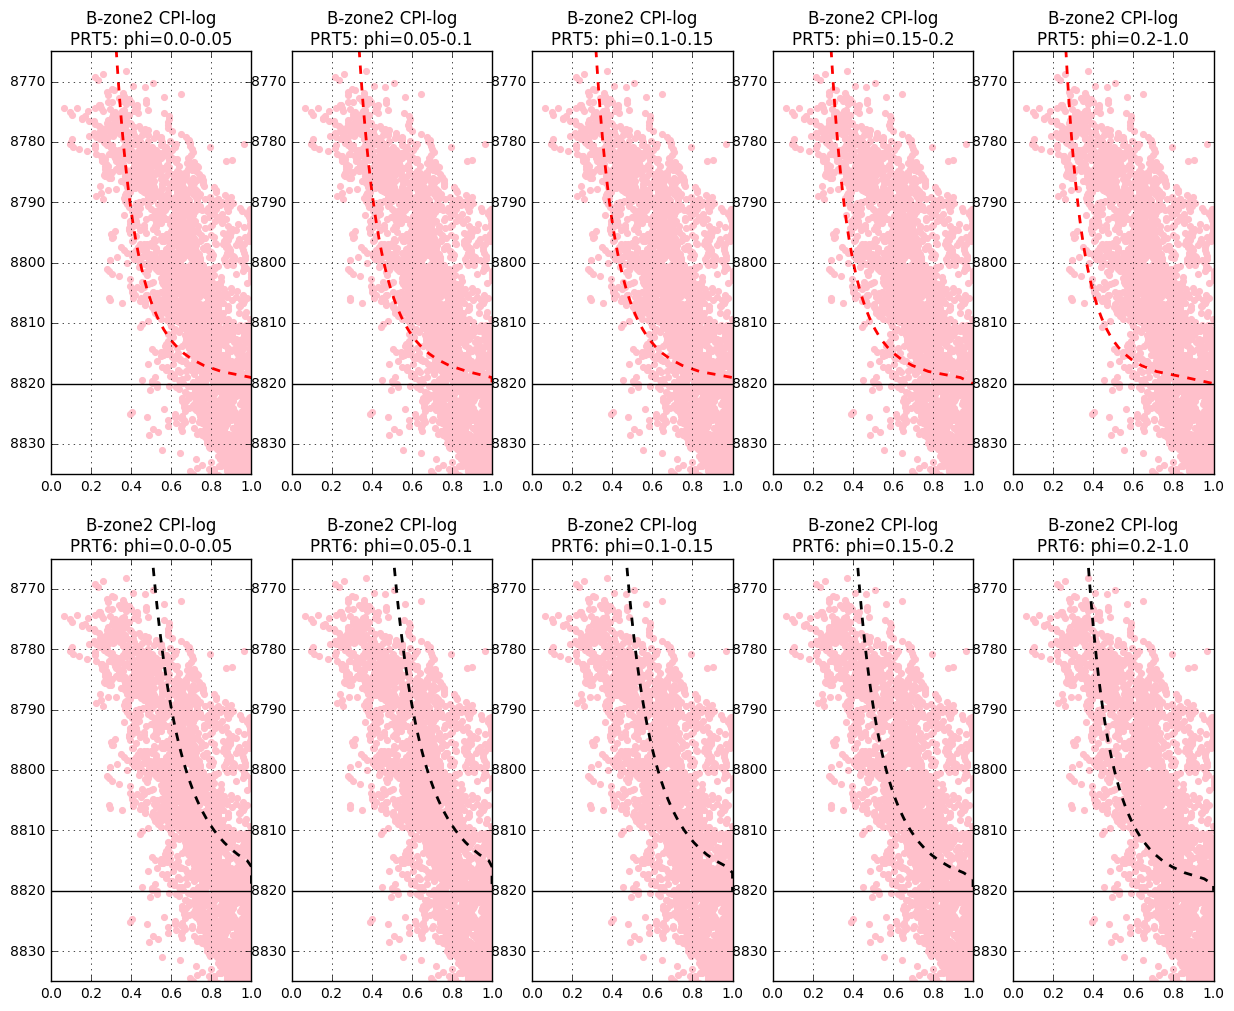

In [1454]:
plt.figure(figsize=(15,12))
i=0
for rt, cc in zip([5, 6], ['r--', 'k--']):
    for phi1, phi2, pnum in zip([0.00, 0.05, 0.10, 0.15, 0.20], [0.05, 0.10, 0.15, 0.20, 1.00],[1,2,3,4,5]):
        i=i+1
        plt.subplot(2,5,i)
        plt.title(st + '-' + zz +' CPI-log\n'+ 'PRT'+str(rt)+ ': phi='+str(phi1)+'-'+str(phi2))
        swoh=fz.SW[(fz.PRT2014==rt) & (fz.PHIE>=phi1) & (fz.PHIE<phi2)]
        ss=fz.SSTVD_Z[(fz.PRT2014==rt) & (fz.PHIE>=phi1) & (fz.PHIE<phi2)]

        plt.scatter(fz.SW,fz.SSTVD_Z, s=17, color="pink")
        plt.scatter(swoh,ss, s=17)
        
        x1 = 'Sw' + str(rt) + '_' + str(pnum)
        plt.plot(df[x1], df.TVDSS, cc, lw=2)

        plt.plot((0, 1), (owc, owc), 'k-')
        plt.xlim(0,1)
        plt.ylim(yrange_min,yrange_max)
        plt.ticklabel_format(useOffset=False)
        plt.gca().invert_yaxis()
        plt.grid(True)

#plt.savefig( 'CPI_PRT56-' +st + '-'+ zz + '.png', bbox_inches='tight') 

# All RST-log
* PRT1,2,3,4 and 5 phi range

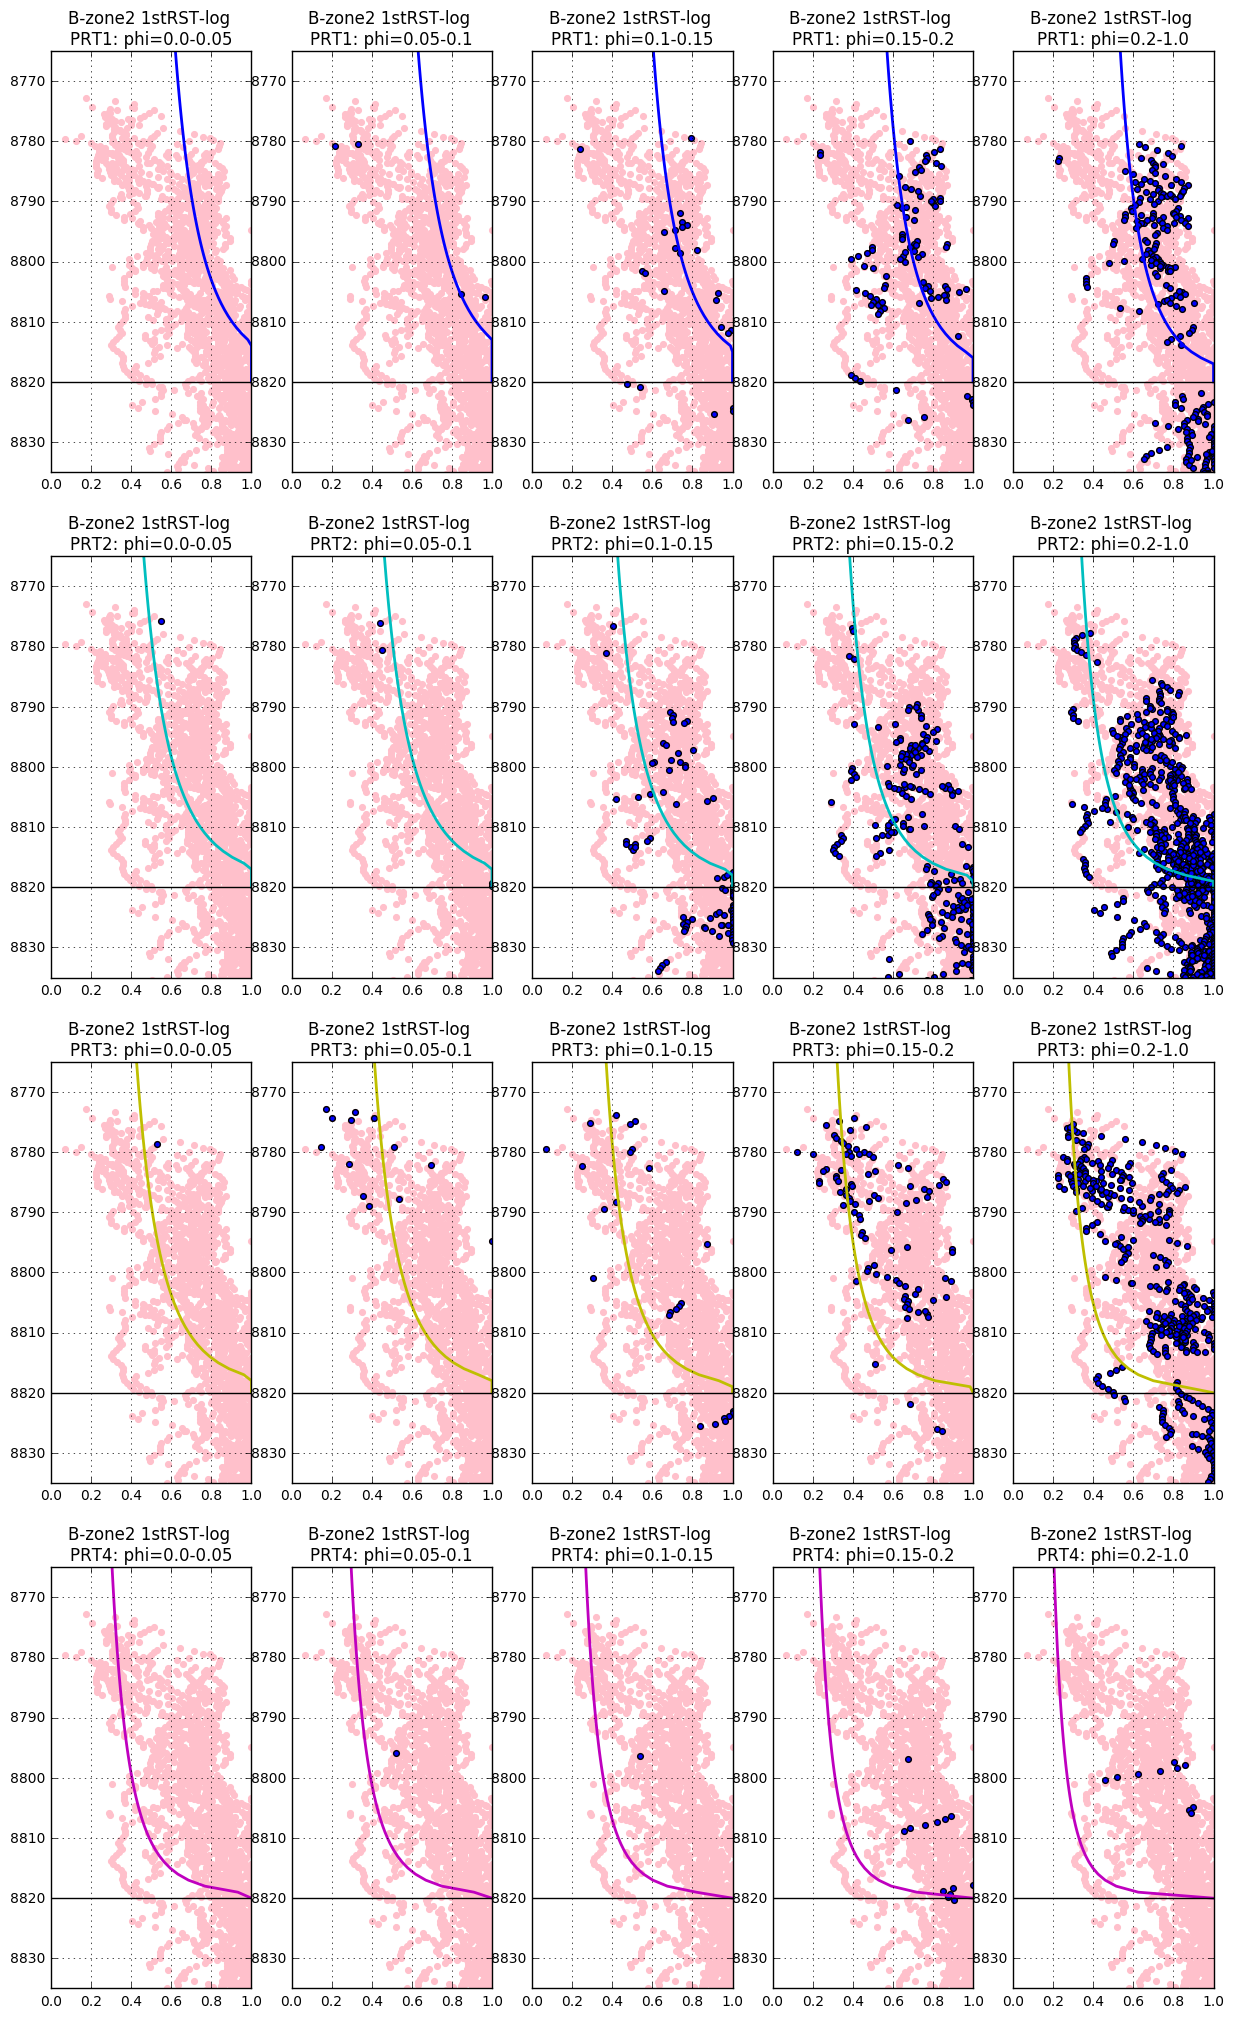

In [1455]:
plt.figure(figsize=(15,25))
i=0
for rt, cc in zip([1, 2, 3, 4], ['b-', 'c-', 'y-', 'm-']):
    for phi1, phi2, pnum in zip([0.00, 0.05, 0.10, 0.15, 0.20], [0.05, 0.10, 0.15, 0.20, 1.00],[1,2,3,4,5]):
        i=i+1
        plt.subplot(4,5,i)
        plt.title(st + '-' + zz +' 1stRST-log \n'+ 'PRT'+str(rt)+ ': phi='+str(phi1)+'-'+str(phi2))

        swoh=fz.RST_SW1[(fz.PRT2014==rt) & (fz.RST_PHIE1>=phi1) & (fz.RST_PHIE1<phi2)]
        ss=fz.SSTVD_Z[(fz.PRT2014==rt) & (fz.RST_PHIE1>=phi1) & (fz.RST_PHIE1<phi2)]
        
        plt.scatter(fz.RST_SW1,fz.SSTVD_Z, s=17, color="pink")
        plt.scatter(swoh,ss, s=17)
        
        x1 = 'Sw' + str(rt) + '_' + str(pnum)
        plt.plot(df[x1], df.TVDSS, cc, lw=2)

        plt.plot((0, 1), (owc, owc), 'k-')
        plt.xlim(0,1)
        plt.ylim(yrange_min,yrange_max)
        plt.ticklabel_format(useOffset=False)
        plt.gca().invert_yaxis()
        plt.grid(True)
        
plt.savefig( 'RST_PRT1234-' +st + '-'+ zz + '.png', bbox_inches='tight')        

# All RST-log
* PRT5, 6 and 5 phi range

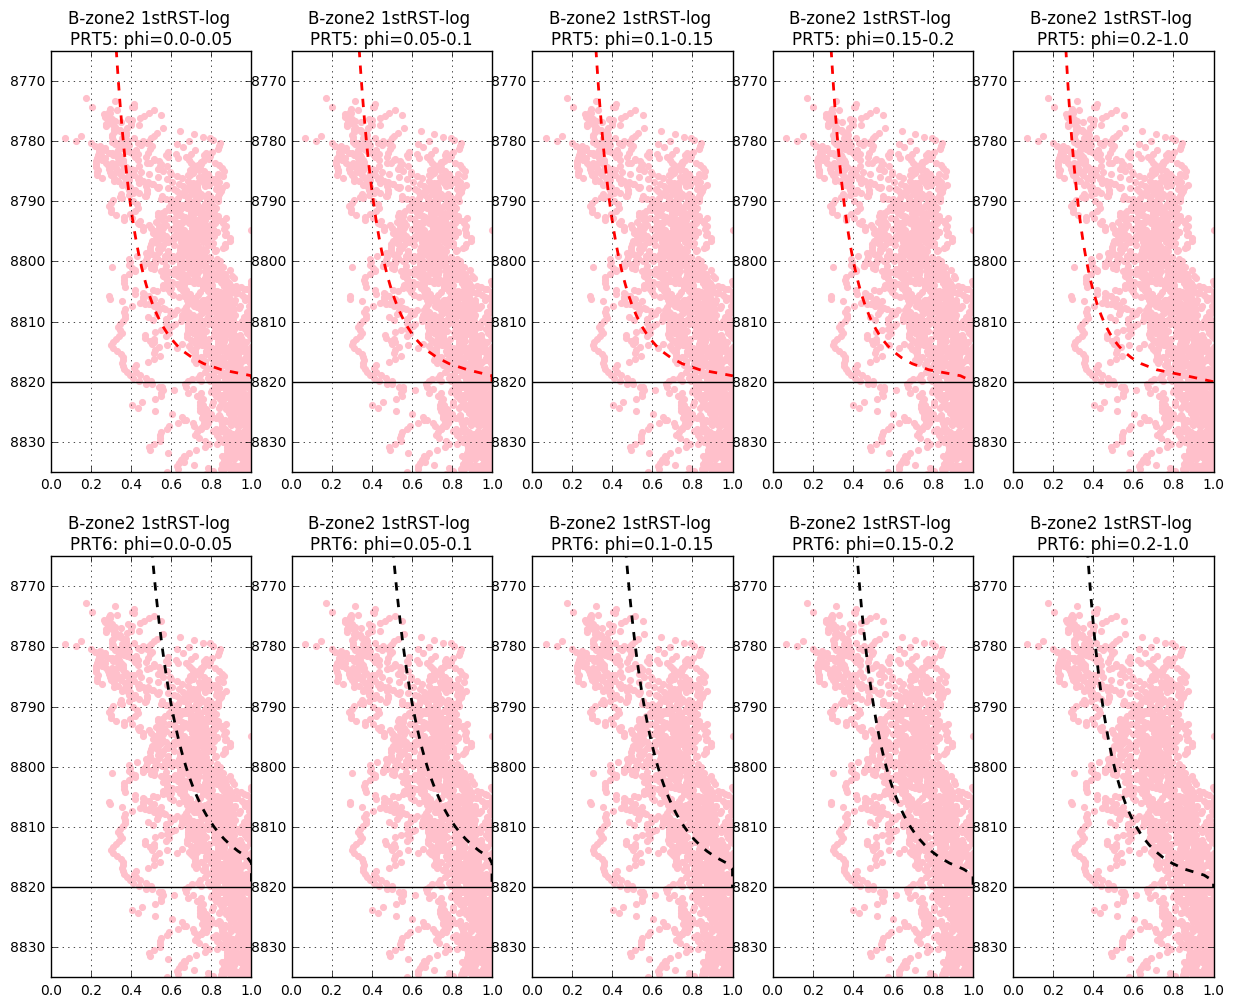

In [1456]:
plt.figure(figsize=(15,25))
i=0
for rt, cc in zip([5, 6], ['r--', 'k--']):
    for phi1, phi2, pnum in zip([0.00, 0.05, 0.10, 0.15, 0.20], [0.05, 0.10, 0.15, 0.20, 1.00],[1,2,3,4,5]):
        i=i+1
        plt.subplot(4,5,i)
        plt.title(st + '-' + zz +' 1stRST-log \n'+ 'PRT'+str(rt)+ ': phi='+str(phi1)+'-'+str(phi2))

        swoh=fz.RST_SW1[(fz.PRT2014==rt) & (fz.RST_PHIE1>=phi1) & (fz.RST_PHIE1<phi2)]
        ss=fz.SSTVD_Z[(fz.PRT2014==rt) & (fz.RST_PHIE1>=phi1) & (fz.RST_PHIE1<phi2)]
        
        plt.scatter(fz.RST_SW1,fz.SSTVD_Z, s=17, color="pink")
        plt.scatter(swoh,ss, s=17)
        
        x1 = 'Sw' + str(rt) + '_' + str(pnum)
        plt.plot(df[x1], df.TVDSS, cc, lw=2)

        plt.plot((0, 1), (owc, owc), 'k-')
        plt.xlim(0,1)
        plt.ylim(yrange_min,yrange_max)
        plt.ticklabel_format(useOffset=False)
        plt.gca().invert_yaxis()
        plt.grid(True)
        
#plt.savefig( 'RST_PRT56-' +st + '-'+ zz + '.png', bbox_inches='tight') 

# 2006 Report RST-log
* PRT1,2,3,4 and 5 phi range

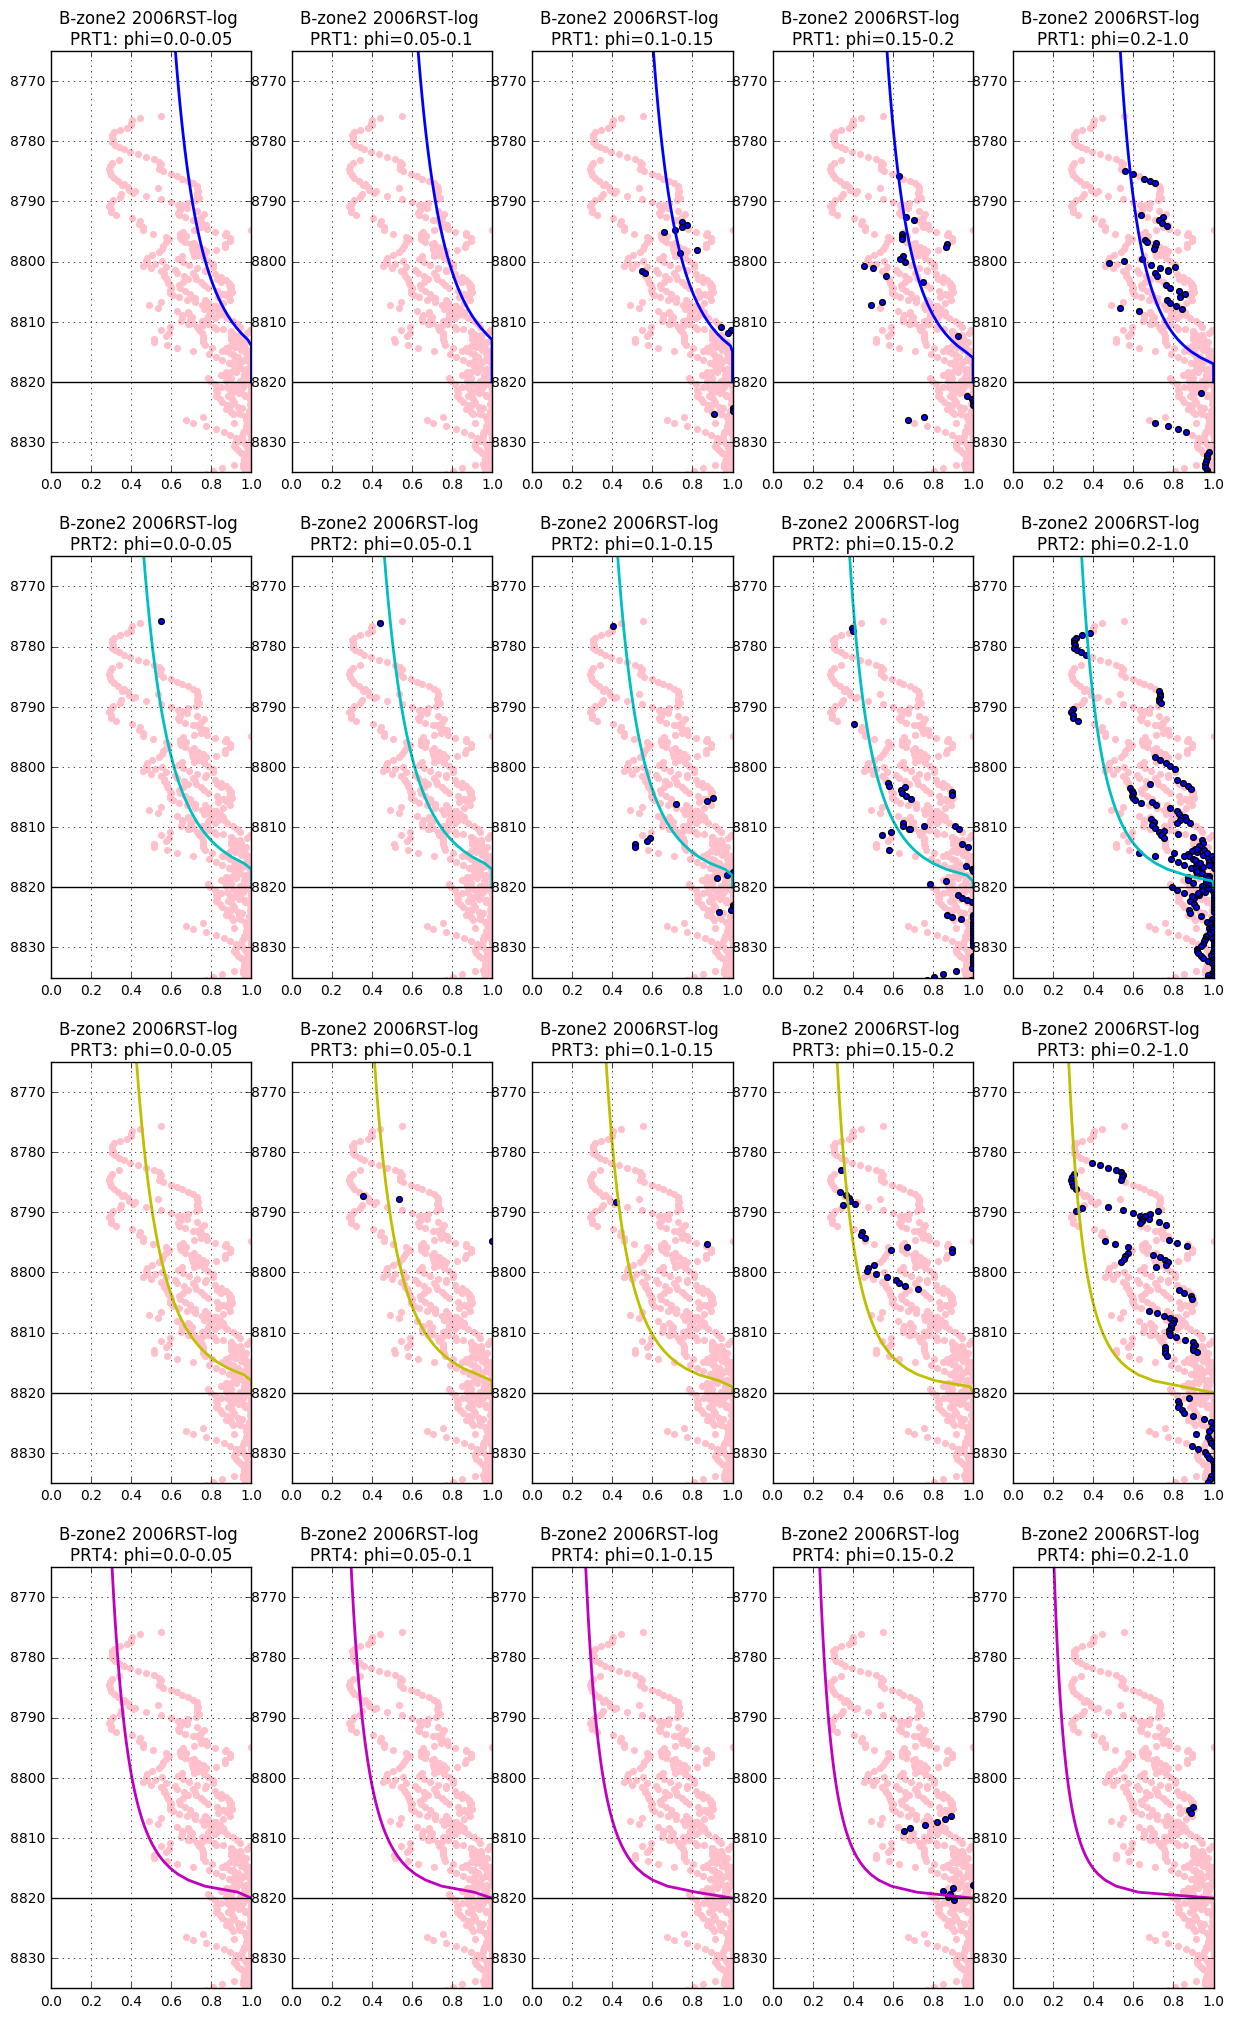

In [1457]:
plt.figure(figsize=(15,25))
i=0
for rt, cc in zip([1, 2, 3, 4], ['b-', 'c-', 'y-', 'm-']):
    for phi1, phi2, pnum in zip([0.00, 0.05, 0.10, 0.15, 0.20], [0.05, 0.10, 0.15, 0.20, 1.00],[1,2,3,4,5]):
        i=i+1
        plt.subplot(4,5,i)
        plt.title(st + '-' + zz +' 2006RST-log \n'+ 'PRT'+str(rt)+ ': phi='+str(phi1)+'-'+str(phi2))
        swoh=fz2006.RST_SW1[(fz2006.PRT2014==rt) & (fz2006.RST_PHIE1>=phi1) & (fz2006.RST_PHIE1<phi2)]
        ss=fz2006.SSTVD_Z[(fz2006.PRT2014==rt) & (fz2006.RST_PHIE1>=phi1) & (fz2006.RST_PHIE1<phi2)]
        
        plt.scatter(fz2006.RST_SW1,fz2006.SSTVD_Z, s=17, color="pink")
        plt.scatter(swoh,ss, s=17)
        
        x1 = 'Sw' + str(rt) + '_' + str(pnum)
        plt.plot(df[x1], df.TVDSS, cc, lw=2)

        plt.plot((0, 1), (owc, owc), 'k-')
        plt.xlim(0,1)
        plt.ylim(yrange_min,yrange_max)
        plt.ticklabel_format(useOffset=False)
        plt.gca().invert_yaxis()
        plt.grid(True)
        
plt.savefig( 'RST2006_PRT1234-' +st + '-'+ zz + '.png', bbox_inches='tight')        

# 2006 Report RST-log
* PRT5,6 and 5 phi range

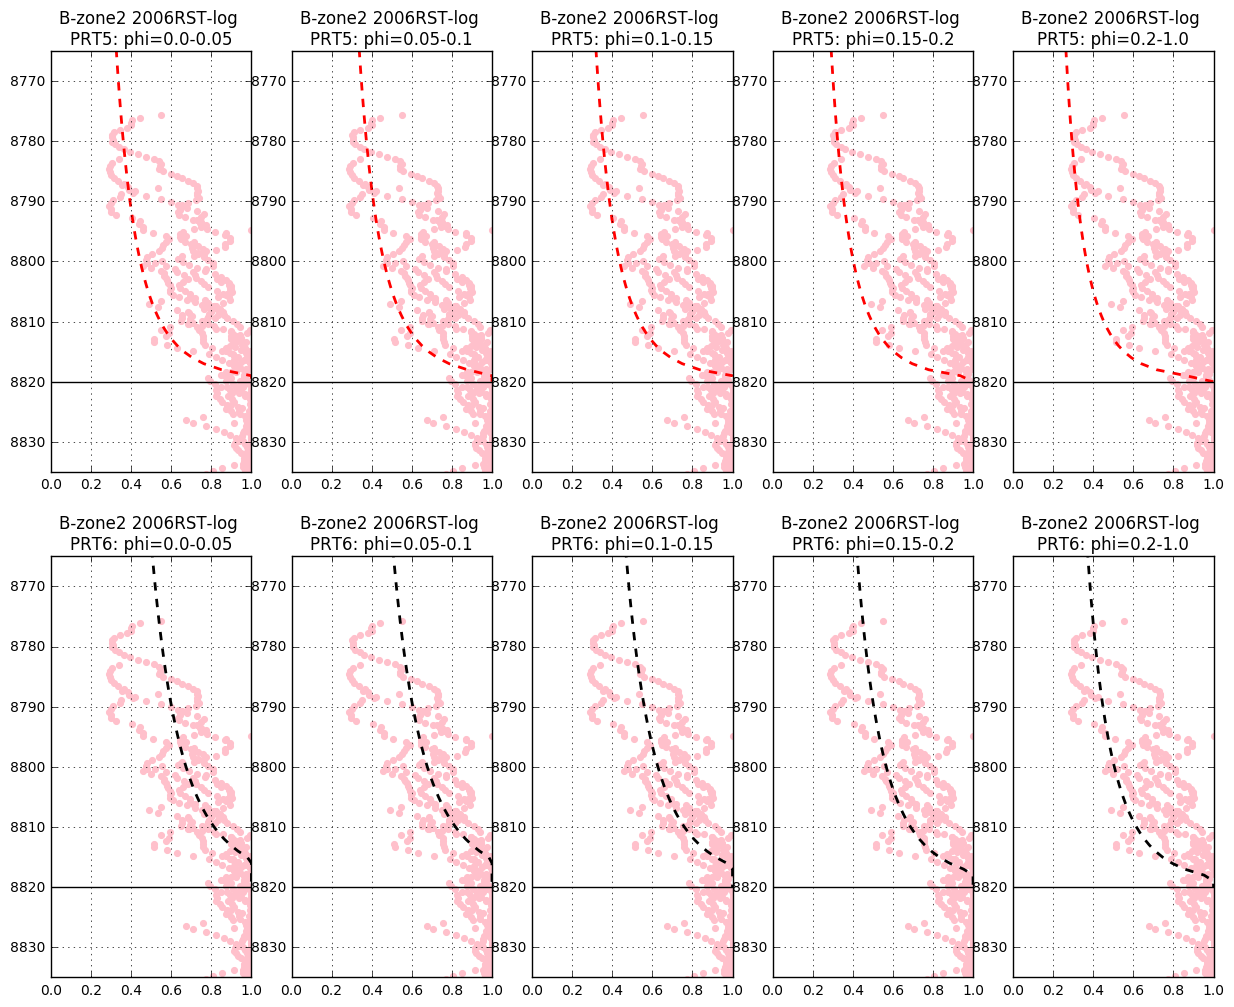

In [1458]:
plt.figure(figsize=(15,25))
i=0
for rt, cc in zip([5, 6], ['r--', 'k--']):
    for phi1, phi2, pnum in zip([0.00, 0.05, 0.10, 0.15, 0.20], [0.05, 0.10, 0.15, 0.20, 1.00],[1,2,3,4,5]):
        i=i+1
        plt.subplot(4,5,i)
        plt.title(st + '-' + zz +' 2006RST-log \n'+ 'PRT'+str(rt)+ ': phi='+str(phi1)+'-'+str(phi2))
        swoh=fz2006.RST_SW1[(fz2006.PRT2014==rt) & (fz2006.RST_PHIE1>=phi1) & (fz2006.RST_PHIE1<phi2)]
        ss=fz2006.SSTVD_Z[(fz2006.PRT2014==rt) & (fz2006.RST_PHIE1>=phi1) & (fz2006.RST_PHIE1<phi2)]
        
        plt.scatter(fz2006.RST_SW1,fz2006.SSTVD_Z, s=17, color="pink")
        plt.scatter(swoh,ss, s=17)
        
        x1 = 'Sw' + str(rt) + '_' + str(pnum)
        plt.plot(df[x1], df.TVDSS, cc, lw=2)

        plt.plot((0, 1), (owc, owc), 'k-')
        plt.xlim(0,1)
        plt.ylim(yrange_min,yrange_max)
        plt.ticklabel_format(useOffset=False)
        plt.gca().invert_yaxis()
        plt.grid(True)
        
#plt.savefig( 'RST2006_PRT56-' +st + '-'+ zz + '.png', bbox_inches='tight')   